This notebook explores the concept of position encoding used in Transformers architecture. 

### Position encoding

Since transformers architecture processes elements in parallel rather than in sequence, it makes no assumption of temporal dependency of elements even when they are a part of a sequence such as a text sentence.

Hence, in the encoding phase of converting word tokens into embedding vectors,before feeding them into the attention layers, an additional vector representation is added to original embeddings obtained in the previous.

This additional vector representation are positional encoding vectors which contain the information of position of tokens in the input sequence.

This vector representation is obtained in following steps -

1. Producing a d_model/2 dimensional vector of shape = (1,d_model/2)
2. Multiply this vector with each position index of input sequence. eg. if the input is has 50 words then multiply each integer in 0 - 49 with the above vector to obatain vector of shape - (50, d_model/2) 
3. Taking sine and cosine of each element for every position & concatenate the 2 values. We will have concatenated vector of shape - (50,d_model) 

This way nearby locations will have similar encodings.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

#### Step 1
The angle rates range from `1 [rads/step]` to `min_rate [rads/step]` over the vector depth.

Formula for angle rate:

$$angle\_rate_d = (min\_rate)^{d / d_{max}} $$

In [2]:
num_positions = 50
depth = 512                    # depth -> d_model
min_rate = 1/10000

assert depth%2 == 0, "Depth must be even."
angle_rate_exponents = np.linspace(0,1,depth//2)
angle_rates = min_rate**(angle_rate_exponents)

The resulting exponent goes from `0` to `1`, causing the `angle_rates` to drop exponentially from `1` to `min_rate`.

In [3]:
angle_rates.shape

(256,)

Text(0, 0.5, 'Angle rate [rads/step]')

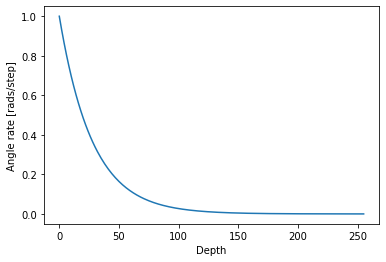

In [6]:
# Plotting initial exponentially decreasing vector
plt.plot(angle_rates)
plt.xlabel('Depth')
plt.ylabel('Angle rate [rads/step]')

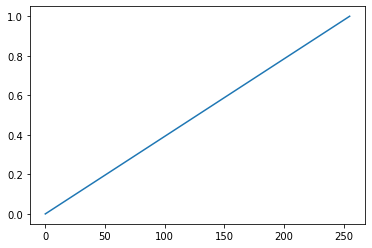

In [7]:
# The exponents array used above
plt.plot(angle_rate_exponents)
plt.show()

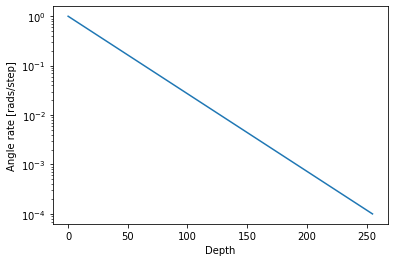

In [8]:
# Since it's an exponential function, let's explore its linearity after applying log scaling
plt.semilogy(angle_rates)
plt.xlabel('Depth')
plt.ylabel('Angle rate [rads/step]')
plt.show()

#### Step - 2
Broadcasting a multiply over angle rates and positions gives a map of 
the position encoding angles as a function of depth.

In [9]:
positions = np.arange(num_positions) 
angle_rads = (positions[:, np.newaxis])*angle_rates[np.newaxis, :]

In [10]:
angle_rads.shape

(50, 256)

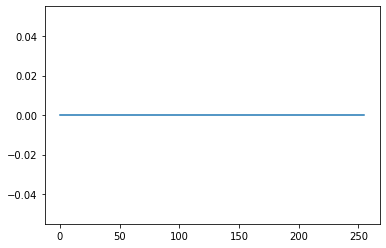

In [12]:
# The 1st vector will be zero since it's multiple with position index 0
plt.plot(angle_rads[0])
plt.show()

Plotting vectors of position 1, 5, 10 & 40.
Notice the similarity of nature of plots. All of them are generated from the same exponentially decaying array obtained previously with the only difference being each of them scaled by the position index.

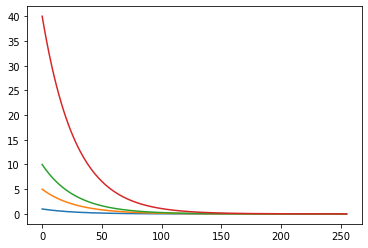

In [16]:
plt.plot(angle_rads[1])
plt.plot(angle_rads[5])
plt.plot(angle_rads[10])
plt.plot(angle_rads[40])
plt.show()

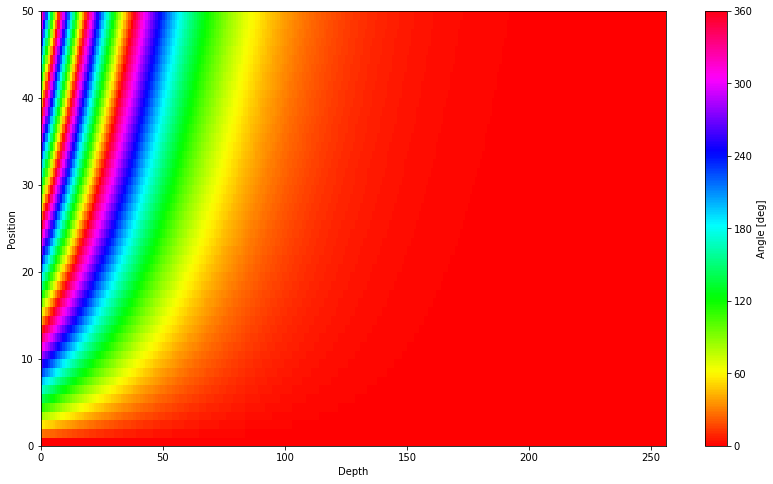

In [17]:
plt.figure(figsize = (14,8))
plt.pcolormesh(
    # Convert to degrees, and wrap around at 360
    angle_rads*180/(2*np.pi) % 360,
    # Use a cyclical colormap so that color(0) == color(360)
    cmap='hsv', vmin=0, vmax=360)

plt.xlim([0,len(angle_rates)])
plt.ylabel('Position')
plt.xlabel('Depth')
bar = plt.colorbar(label='Angle [deg]')
bar.set_ticks(np.linspace(0,360,6+1))

Raw angles are not a good model input (they're either unbounded, or discontinuous). So take the sine and cosine:

In [19]:
sines = np.sin(angle_rads)
cosines = np.cos(angle_rads)
pos_encoding = np.concatenate([sines, cosines], axis=-1)

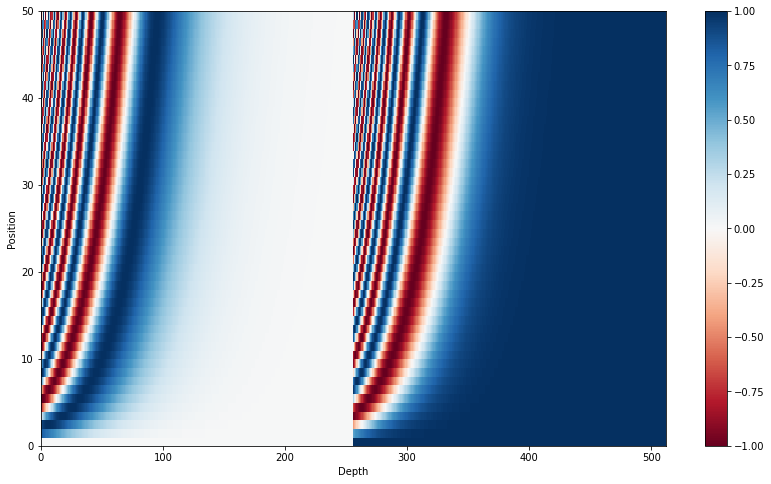

In [20]:
plt.figure(figsize=(14,8))
plt.pcolormesh(pos_encoding, 
               # Use a diverging colormap so it's clear where zero is.
               cmap='RdBu', vmin=-1, vmax=1)
plt.xlim([0,depth])
plt.ylabel('Position')
plt.xlabel('Depth')
plt.colorbar()

### Nearby locations 

Nearby locations will have similar position-encoding vectors. 

To demonstrate compare one position's encoding (here position 20) with each of the others:

In [22]:
pos_encoding_at_20 = pos_encoding[20]

dots = np.dot(pos_encoding,pos_encoding_at_20)
SSE = np.sum((pos_encoding - pos_encoding_at_20)**2, axis=1)

Regardless of how you compare the vectors, they are most similar 20, and clearly diverge as you move away:

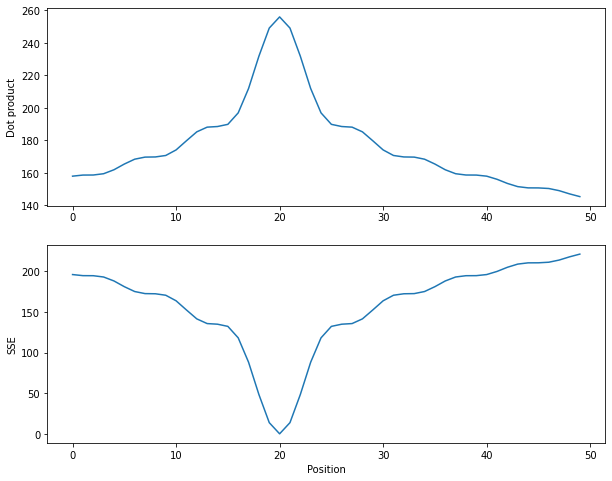

In [26]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylabel('Dot product')
plt.subplot(2,1,2)
plt.plot(SSE)
plt.ylabel('SSE')
plt.xlabel('Position')
plt.show()

#### References -
* https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb
* [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf)